<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/1616847-%D0%A4%D0%B8%D0%BE%D0%BB%D0%B5%D1%82%D0%BE%D0%B2%D0%BE-%D1%80%D0%BE%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9/%D0%A4%D0%B8%D0%BE%D0%BB%D0%B5%D1%82%D0%BE%D0%B2%D0%BE-%D1%80%D0%BE%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сохранить ч/б изображение в оттенках двух цветов с помощью Pillow

К моему [ответу](https://ru.stackoverflow.com/a/1616860/430734) на
[вопрос ruSO](https://ru.stackoverflow.com/q/1616847/430734).

## Техническое

Встроенные изображения от Pillow сравнительно тяжелые, а Github любит
лёгкие. Лично мне, способы оптимизации для Pillow неизвестны, так что
компактные встроенные изображения печатаем Matplotlib-ом.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs = {'pil_kwargs': {'optimize': True}}
%config InlineBackend.figure_formats = [ "jpeg" ]  # Режем для
mpl.rcParams['figure.dpi'] = 150

def gray_inline(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    plt.show()

def rgb_inline(img):
    fig, ax = plt.subplots()
    ax.imshow(img)
    plt.show()

Кроме того, при открытии из Colab, нужно подгрузить с Github оригинальную картинку.

In [2]:
if 'google.colab' in str(get_ipython().config):
    import os
    try:
        import github
    except ModuleNotFoundError:
        %pip install -q PyGithub
        import github

    ipnb_owner, ipnb_repo, ipnb_cbt, ipnb_path, ipnb_files = (
        'Serge3leo', 'temp-cola', 'main',
        'ruSO/1616847-Фиолетово-розовый',
        ["Guerrillero Heroico.jpg"])

    token = os.environ.get('GITHUB_RO_TOKEN')  # Лучше rate limit
    auth = github.Auth.Token(token) if token else None
    g = github.Github(auth=auth)
    print(f"{g.get_user()=}")

    repo = g.get_repo(f"{ipnb_owner}/{ipnb_repo}")
    for fn in ipnb_files:
        contents = repo.get_contents(f"{ipnb_path}/{fn}", ref=ipnb_cbt)
        with open(fn, "wb") as fo:
            fo.write(contents.decoded_content)

## Импорты

In [3]:
from collections import namedtuple
import numpy as np
from PIL import Image, ImageOps

# Героический партизан

В оригинале, был в "оттенках от чёрного до белого".

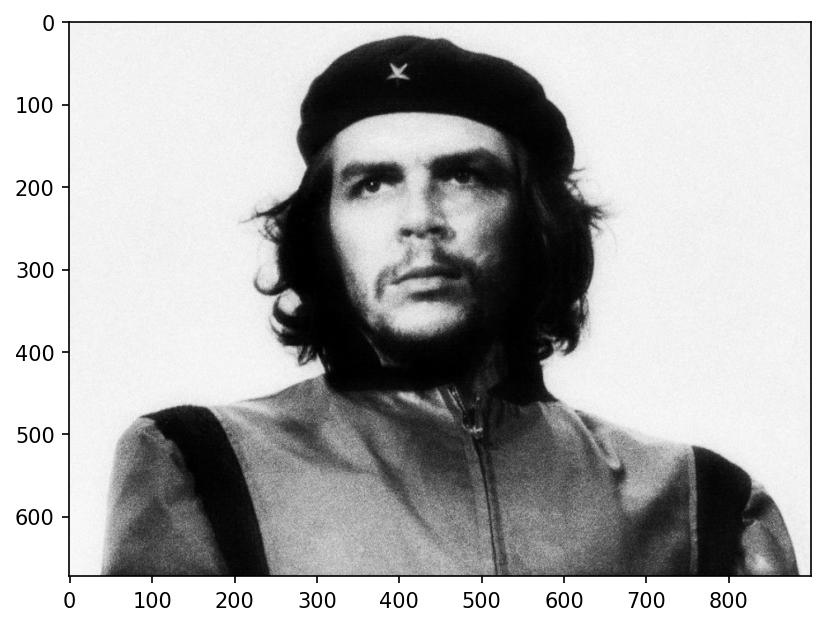

In [4]:
che = ImageOps.grayscale(Image.open("Guerrillero Heroico.jpg"))
gray_inline(che)

## Фиолетово-розовый (RGB)

Если во главу угла поставить "от фиолетового до розового".

In [5]:
violet = np.array((105, 0, 198), dtype=np.uint8)
pink = np.array((255, 192, 203), dtype=np.uint8)

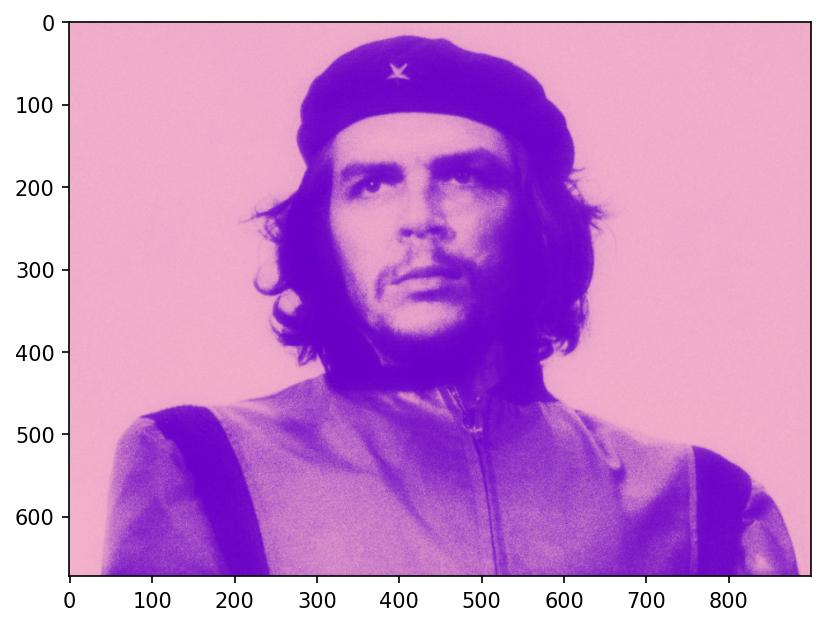

In [6]:
grey = np.asarray(che)
vpche = Image.fromarray(np.uint8(
            violet + np.einsum('ij,k', grey,
                               (pink - violet) / np.iinfo(grey[0, 0]).max)
            ))
rgb_inline(vpche)

## Градации фиолетового

Но, возможно. имелось ввиду так?

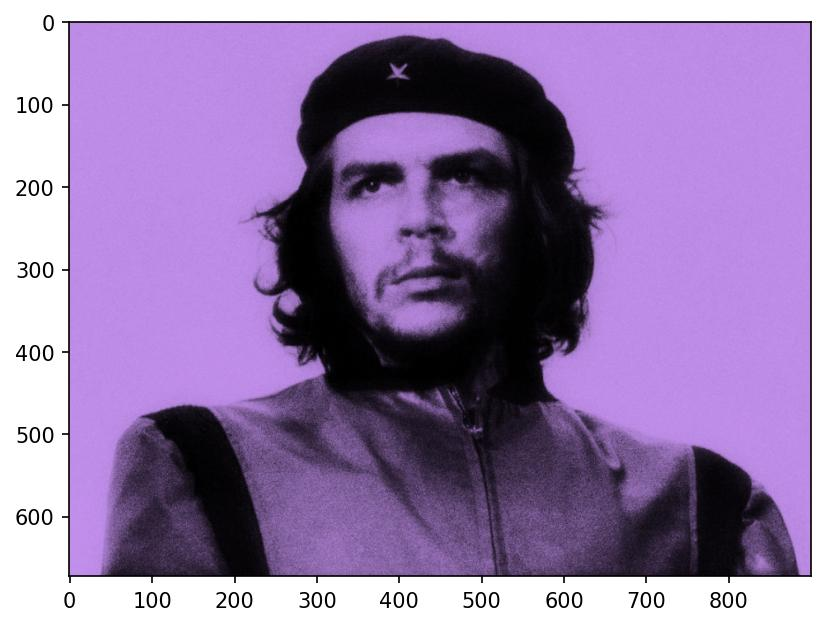

In [7]:
hsv = namedtuple('hsv', 'H S V')
hsv_violet = hsv(272., 100., 78.)

vche = Image.merge('HSV', (
            Image.fromarray(np.full(che.size[::-1], hsv_violet.H*256/360, np.uint8)),
            Image.fromarray(np.full(che.size[::-1], hsv_violet.S, np.uint8)),
            che
        )).convert('RGB')
rgb_inline(vche)

## Градации розового

Или так?

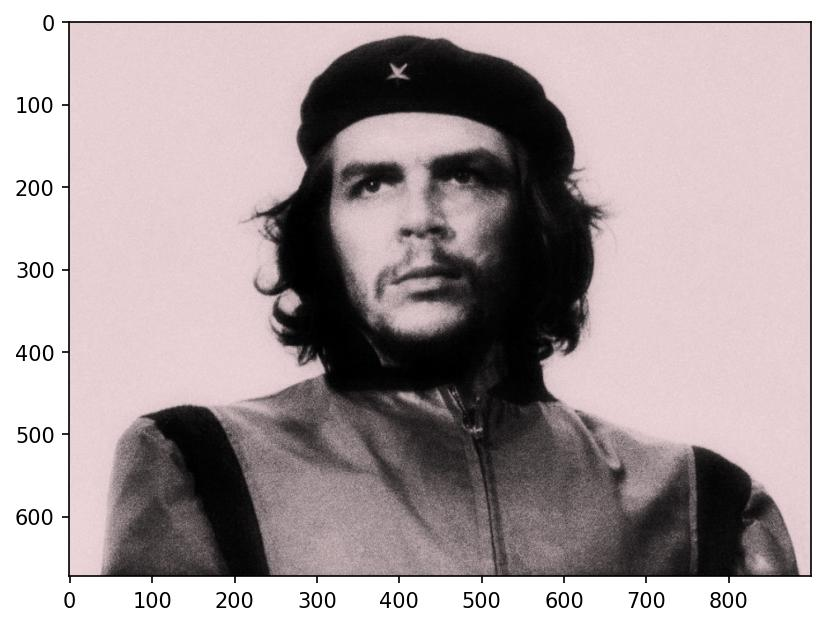

In [8]:
hsv_pink = hsv(350., 25., 100.)

vche = Image.merge('HSV', (
            Image.fromarray(np.full(che.size[::-1], hsv_pink.H*256/360, np.uint8)),
            Image.fromarray(np.full(che.size[::-1], hsv_pink.S, np.uint8)),
            che
        )).convert('RGB')
rgb_inline(vche)

## Псевдосмешение (dithering)

Можно сфокусироваться на "двух цветах" и предложить человеческому глазу
интерполировать так, как ему удобнее, получив результат с
использованием пикселей только двух заданных цветов в технике
псевдосмешения цветов (dithering). Т.е. в зависимости от яркости менять
соотношение плотности пикселей.

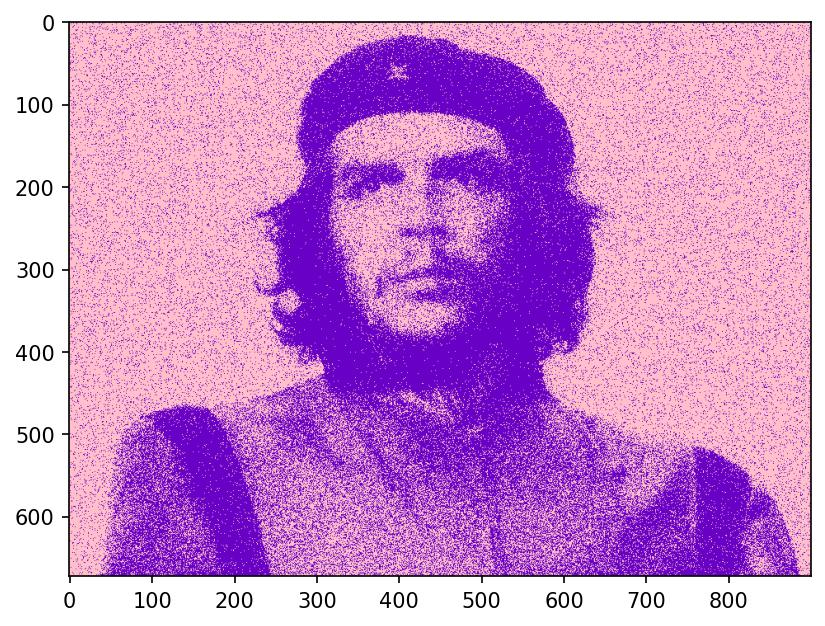

In [9]:
rng = np.random.default_rng()
gidx = grey < rng.integers(np.iinfo(grey[0, 0]).max, endpoint=True,
                           dtype=grey.dtype, size=grey.shape)
d1vpche = Image.merge('RGB', (
            Image.fromarray(np.where(gidx, violet[0], pink[0])),
            Image.fromarray(np.where(gidx, violet[1], pink[1])),
            Image.fromarray(np.where(gidx, violet[2], pink[2]))
        ))
rgb_inline(d1vpche)

А можно "фантазийно" псевдосмешать компоненты цветов.

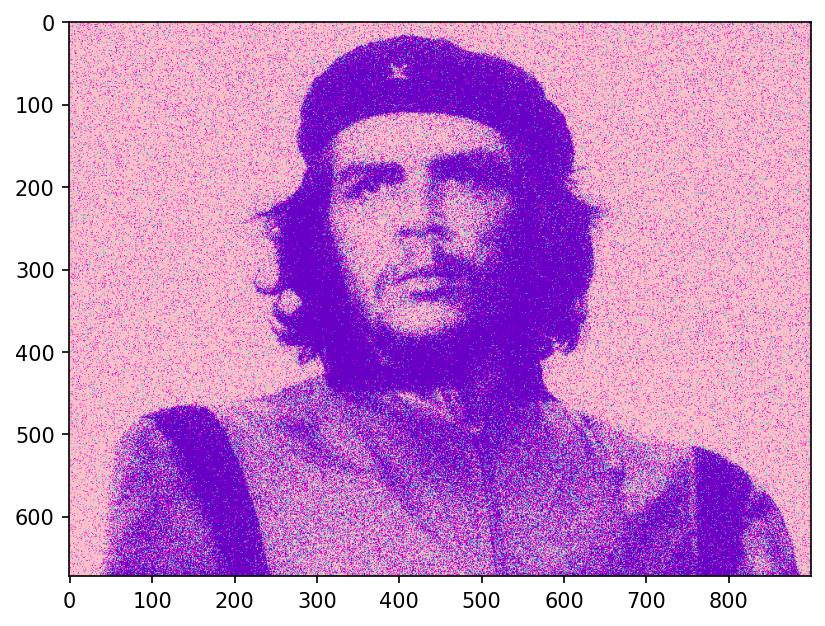

In [10]:
gidx = grey < rng.integers(np.iinfo(grey[0, 0]).max, endpoint=True,
                           dtype=grey.dtype, size=grey.shape)
d2vpche = Image.merge('RGB', (
            Image.fromarray(
                np.where(grey < rng.integers(np.iinfo(grey[0, 0]).max,
                                             endpoint=True, dtype=grey.dtype,
                                             size=grey.shape),
                         violet[0], pink[0])),
            Image.fromarray(
                np.where(grey < rng.integers(np.iinfo(grey[0, 0]).max,
                                             endpoint=True, dtype=grey.dtype,
                                             size=grey.shape),
                         violet[1], pink[1])),
            Image.fromarray(
                np.where(grey < rng.integers(np.iinfo(grey[0, 0]).max,
                                             endpoint=True, dtype=grey.dtype,
                                             size=grey.shape),
                         violet[2], pink[2]))
        ))
rgb_inline(d2vpche)